<a href="https://colab.research.google.com/github/AlekseyTsar3vi4/COMP60003/blob/main/Main_Code_for_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chi-Square Statistic: 513.9226666666667, p-value: 8.887120316117064e-114

Missing values:
 Username           0
Computer ID        0
Connection Time    0
IP Address         0
Label              0
dtype: int64

Unique values per feature:
 Username            566
Computer ID          50
Connection Time    1468
IP Address          126
Label                 2
dtype: int64

Summary statistics:
        Username Computer ID Connection Time   IP Address Label
count      1500        1500            1500         1500  1500
unique      566          50            1468          126     2
top       C1998        TD58        08:17:52  172.16.2.48     A
freq          9          40               3           41  1189


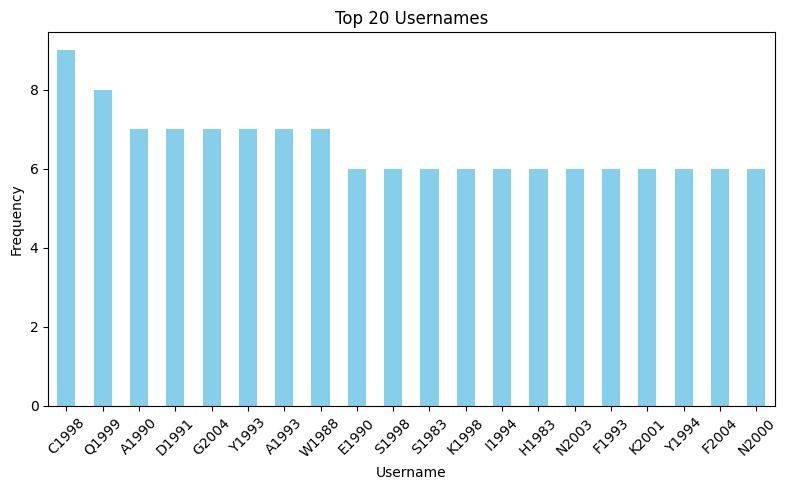

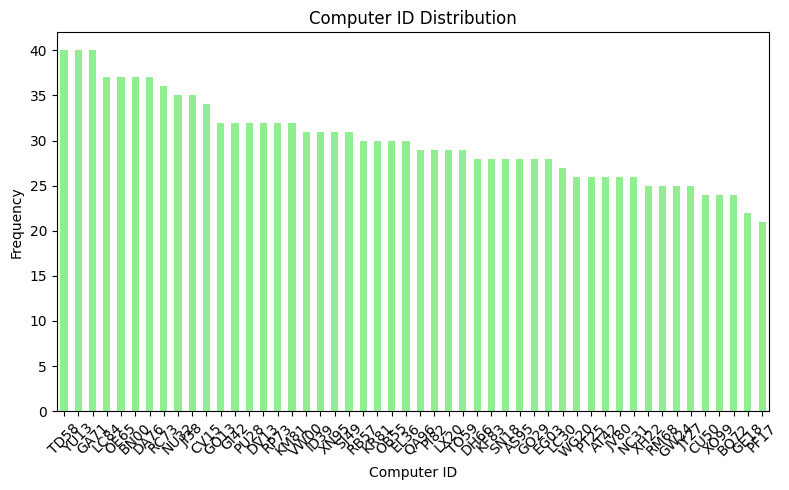

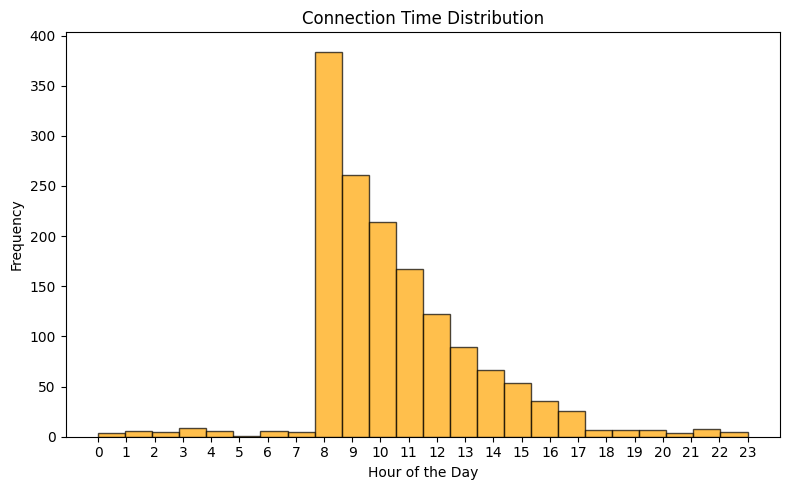

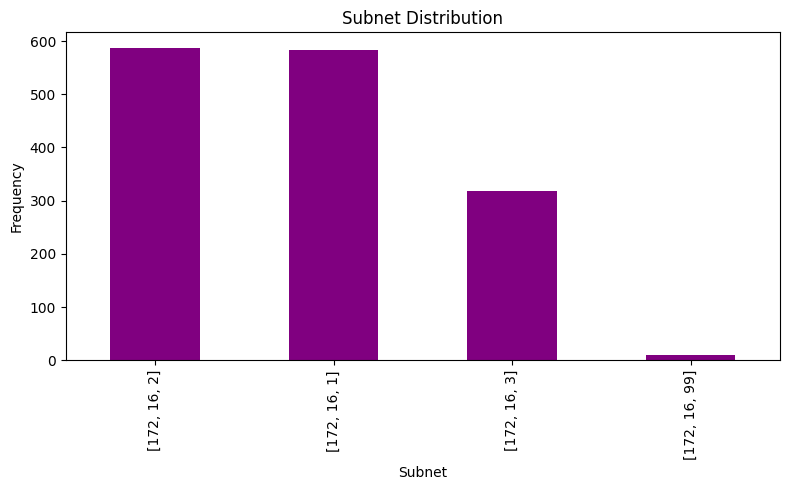

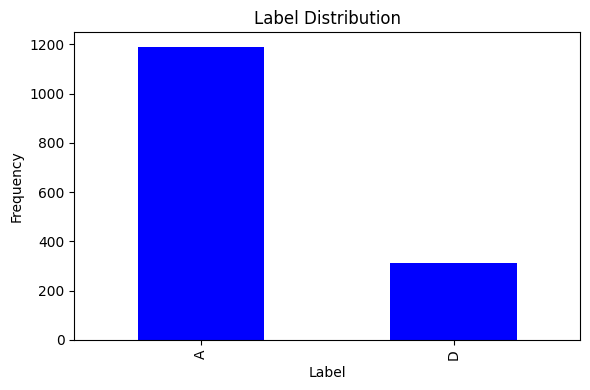


Dataset saved as synthetic_authentication_data_2025-01-04_19-27-14.csv



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.stats import poisson, norm, chisquare
from datetime import datetime

### Define constants ###
num_requests = 1500  # Number of login attempts
num_users = 200      # Number of users
num_computers = 50   # Number of computers

### Step 1: Generate Username ###
def generate_username():
    letter = chr(np.random.randint(65, 90))  # Random uppercase letter (Using ASCII code)
    year = np.random.randint(1980, 2005)
    return f"{letter}{year}"

usernames = [generate_username() for _ in range(num_requests)]

# Normalize usernames if needed for ML (e.g., encoding A1985 as a number):
# username_encoded = pd.factorize(usernames)[0]  # Convert to numerical representation

### Step 2: Generate Computer ID ###
unique_computers = [
    f"{chr(np.random.randint(65, 90))}{chr(np.random.randint(65, 90))}{str(np.random.randint(0, 10))}{str(np.random.randint(0, 10))}"
    for _ in range(num_computers)
]

# Assign computer IDs randomly using a binomial-like selection
computers = [np.random.choice(unique_computers) for _ in range(num_requests)]

# One-Hot Encoding for numerical representation if needed in machine learning models:
# computer_encoded = pd.get_dummies(pd.Series(computers), prefix="Computer ID")

### Step 3: Generate Connection ###
def generate_connection_time():
    # Define the time window for active hours (8 AM to 6 PM) in seconds
    start_time = 8 * 3600                  # 8 AM in seconds
    end_time = 18 * 3600                   # 6 PM in seconds
    active_period = end_time - start_time  # Active period in seconds (10 hours)

    # 90% of the time, generate a connection time within the active hours
    if np.random.rand() < 0.9:
        random_time_within_period = int(np.random.exponential(scale=active_period / 3)) % active_period
        total_seconds = start_time + random_time_within_period
    else:
        # 10% of the time, generate a connection time outside active hours
        total_seconds = int(np.random.uniform(0, 24 * 3600))  # Randomly across the day

    # Convert total seconds into HH:MM:SS format
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{hours:02}:{minutes:02}:{seconds:02}"

connection_times = [generate_connection_time() for _ in range(num_requests)]

### Step 4: Generate IP Address ###

# Define private subnets
subnets = ["172.16.1.", "172.16.2.", "172.16.3.", "172.16.99."]

def generate_ip_address():
    # Select a random private subnet
    subnet = np.random.choice(subnets, p=[0.4, 0.4, 0.195, 0.005]) # Adding weight
    # Generate a host value using Poisson distribution with λ=50 (for clustering aroung value of 50).
    host = max(1, min(poisson.rvs(50), 254))
    return f"{subnet}{host}"

# Generate IP addresses for all login requests
ip_addresses = [generate_ip_address() for _ in range(num_requests)]

### Step 5: Generate Labels (Accept/Deny) ###
def generate_label(connection_time):
    # Extract the hour from the connection time
    hour = int(connection_time.split(':')[0])

    # Generate a random value from a normal distribution
    score = norm.rvs(loc=0.5, scale=0.1)  # Mean of 0.5 and standard deviation of 0.1

    # Adjust threshold based on working hours
    if hour < 8 or hour >= 18:  # Non-working hours
        return "D" if score < 0.6 else "A"  # Shift threshold slightly toward "Deny"
    else:  # Working hours
        return "A" if score > 0.4 else "D"  # Shift threshold slightly toward "Accept"

labels = [generate_label(time) for time in connection_times]

# Perform a chi-square test to verify statistical randomness and balance

observed = pd.Series(labels).value_counts()
chi2_stat, p_value = chisquare(observed)
print(f"Chi-Square Statistic: {chi2_stat}, p-value: {p_value}\n")

#### Combine all features into a DataFrame ###
df = pd.DataFrame({
    'Username': usernames,
    'Computer ID': computers,
    'Connection Time': connection_times,
    'IP Address': ip_addresses,
    'Label': labels
})

### Data Profiling ###
print("Missing values:\n", df.isnull().sum())
print("\nUnique values per feature:\n", df.nunique())
print("\nSummary statistics:\n", df.describe(include='all'))

### Visualizations ###

# 1. Username Distribution (Bar Chart)
plt.figure(figsize=(8, 5))
df['Username'].value_counts().head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Usernames')
plt.xlabel('Username')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Computer ID Distribution (Bar Chart)
plt.figure(figsize=(8, 5))
df['Computer ID'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Computer ID Distribution')
plt.xlabel('Computer ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Connection Time Distribution (Histogram)
hours = [int(time.split(':')[0]) for time in connection_times]
plt.figure(figsize=(8, 5))
plt.hist(hours, bins=24, color='orange', alpha=0.7, edgecolor='black')
plt.title("Connection Time Distribution")
plt.xlabel("Hour of the Day")
plt.ylabel("Frequency")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# 4. Subnet Distribution (Bar Chart)
plt.figure(figsize=(8, 5))
pd.Series([ip.split('.')[0:3] for ip in ip_addresses]).value_counts().plot(kind='bar', color='purple')
plt.title("Subnet Distribution")
plt.xlabel("Subnet")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 5. Label Distribution (Bar Chart)
plt.figure(figsize=(6, 4))
df['Label'].value_counts().plot(kind='bar', color='blue')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Save the dataset
filename = f"synthetic_authentication_data_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
df.to_csv(filename, index=False)
print(f"\nDataset saved as {filename}\n")